# Objetivo: Regressão no dataset "Real estate valuation" (UCI), usando MLP.
    - Avaliação por validação cruzada k-fold e análise de resíduos.


In [2]:
from ucimlrepo import fetch_ucirepo

import numpy as np
from sklearn.preprocessing import QuantileTransformer, StandardScaler
import random
import itertools


from trabalho_ic_aplicada.models import aux
from trabalho_ic_aplicada.models import reg_mlp

2025-08-11 20:26:44.037 | INFO     | trabalho_ic_aplicada.config:<module>:11 - PROJ_ROOT path is: /home/apo-note/Documents/Github/Trabalhos_IC_Aplicada


In [3]:
# fetch dataset
real_estate_valuation = fetch_ucirepo(id=477)

features = real_estate_valuation.variables.iloc[1:, 0].values
# data (as pandas dataframes)
X = real_estate_valuation.data.features.to_numpy()

# Removendo a primeira coluna (X1 transaction date) que não é um atributo relevante, segundo analise.
X = X[:, 1:]

y = real_estate_valuation.data.targets.to_numpy().ravel()


k_fold = aux.validacao_cruzada_kfold(X,y,k=10)


### Random Search e Avaliação Melhor Caso MLP.

In [4]:


def cross_val_mlp(X, y, k_fold, layer_sizes, activation, epochs, lr):
    """
    Executa CV para um MLP com N camadas ocultas (definidas em layer_sizes),
    retorna média de R2 e todas as curvas de loss.
    """
    fold_r2 = []
    fold_losses = []
    for train_idx, test_idx in k_fold:
        X_tr, X_te = X[train_idx], X[test_idx]
        y_tr, y_te = y[train_idx].reshape(-1,1), y[test_idx].reshape(-1,1)

        # Normaliza X (fit no treino, transform no teste)
        scaler = QuantileTransformer(
            n_quantiles=min(X_tr.shape[0], 1000),
            output_distribution='uniform'
        )
        X_tr_n = scaler.fit_transform(X_tr)
        X_te_n = scaler.transform(X_te)

        # Treina
        W, loss_hist = reg_mlp.train_mlp_regression(
            X_tr_n, y_tr,
            layer_sizes=layer_sizes,           # ex.: [D, H1, H2, 1]
            epochs=epochs,
            eta_i=lr, eta_f=lr,
            hidden_activation=activation,
            output_activation='linear',
            verbose=False
        )
        fold_losses.append(loss_hist)

        # Previsão
        y_pred = reg_mlp.predict_mlp_regression(X_te_n, W, activation, 'linear').reshape(-1,1)

        # Métrica (R²)
        _, _, r2, *_ = aux.calcular_metricas(y_te, y_pred, aux)
        fold_r2.append(r2)

    return np.mean(fold_r2), fold_losses


def random_search_2hidden(X, y, k_fold,
                          hidden1_list, hidden2_list,
                          activations, epochs_list, lrs,
                          n_iter=40, seed=42):
    """
    Busca aleatória para MLP com DUAS camadas ocultas.
    Otimiza H1 e H2 separadamente.

    Parâmetros:
        hidden1_list: lista de inteiros para nº de neurônios da 1ª oculta (H1)
        hidden2_list: lista de inteiros para nº de neurônios da 2ª oculta (H2)
        activations:  lista de strings (ex.: ['relu','tanh','sigmoid'])
        epochs_list:  lista de int
        lrs:          lista de floats (taxas de aprendizado)
        n_iter:       nº de configs aleatórias a avaliar
        seed:         semente para reprodutibilidade
    """
    random.seed(seed)
    np.random.seed(seed)

    # todas as combinações possíveis
    all_combinations = list(itertools.product(activations, hidden1_list, hidden2_list, epochs_list, lrs))
    # amostra aleatória
    sampled = random.sample(all_combinations, min(n_iter, len(all_combinations)))

    best = {'score': -np.inf}
    for act, h1, h2, ep, lr in sampled:
        layer_sizes = [X.shape[1], h1, h2, 1]
        mean_r2, _ = cross_val_mlp(X, y, k_fold, layer_sizes, act, ep, lr)
        print(f"Act={act:<7} H1={h1:3d} H2={h2:3d} Ep={ep:3d} LR={lr:.3g} → R²={mean_r2:.4f}")

        if mean_r2 > best['score']:
            best.update({
                'layer_sizes': layer_sizes,
                'activation': act,
                'epochs': ep,
                'lr': lr,
                'score': mean_r2
            })

    print("\n=== Best config (2 hidden) ===")
    print(best)
    return best

In [5]:

# 1) Grid search
activations   = ['sigmoid', 'tanh', 'relu', 'leaky_relu']
epochs_list   = [100, 200, 300]

# 1) Random search
best_cfg = random_search_2hidden(
    X, y, k_fold,
    hidden1_list=[4, 8, 16, 32, 64],
    hidden2_list=[4, 8, 16, 32, 64],
    activations=activations,
    epochs_list=[100, 200, 300],
    lrs=[1e-3, 5e-3, 1e-2],
    n_iter=40,
    seed=42
)  # você pode ajustar n_iter

Act=relu    H1= 64 H2= 16 Ep=300 LR=0.001 → R²=0.6335
Act=sigmoid H1= 16 H2= 16 Ep=300 LR=0.001 → R²=0.6607
Act=sigmoid H1=  4 H2= 16 Ep=300 LR=0.005 → R²=0.6416
Act=leaky_relu H1=  8 H2= 64 Ep=200 LR=0.001 → R²=0.4498
Act=tanh    H1=  8 H2=  8 Ep=100 LR=0.01 → R²=0.2070
Act=tanh    H1=  4 H2= 16 Ep=300 LR=0.005 → R²=0.6218
Act=tanh    H1=  4 H2=  4 Ep=200 LR=0.001 → R²=0.6105
Act=sigmoid H1= 32 H2=  4 Ep=300 LR=0.005 → R²=0.6483


/home/apo-note/Documents/Github/Trabalhos_IC_Aplicada/trabalho_ic_aplicada/models/reg_mlp.py:181: RuntimeWarning: overflow encountered in matmul
  gradients[i] = delta_col @ activation_row
/home/apo-note/Documents/Github/Trabalhos_IC_Aplicada/trabalho_ic_aplicada/models/reg_mlp.py:187: RuntimeWarning: overflow encountered in matmul
  error_prev = W_no_bias.T @ delta
/home/apo-note/Documents/Github/Trabalhos_IC_Aplicada/trabalho_ic_aplicada/models/reg_mlp.py:181: RuntimeWarning: invalid value encountered in matmul
  gradients[i] = delta_col @ activation_row
/home/apo-note/Documents/Github/Trabalhos_IC_Aplicada/trabalho_ic_aplicada/models/reg_mlp.py:264: RuntimeWarning: overflow encountered in square
  epoch_squared_error += 0.5 * np.sum(error**2)
/home/apo-note/Documents/Github/Trabalhos_IC_Aplicada/trabalho_ic_aplicada/models/reg_mlp.py:181: RuntimeWarning: overflow encountered in matmul
  gradients[i] = delta_col @ activation_row
/home/apo-note/Documents/Github/Trabalhos_IC_Aplicada/t

Act=leaky_relu H1=  8 H2= 32 Ep=300 LR=0.005 → R²=nan
Act=sigmoid H1= 16 H2=  8 Ep=200 LR=0.01 → R²=0.6500


/home/apo-note/Documents/Github/Trabalhos_IC_Aplicada/trabalho_ic_aplicada/models/reg_mlp.py:181: RuntimeWarning: overflow encountered in matmul
  gradients[i] = delta_col @ activation_row
/home/apo-note/Documents/Github/Trabalhos_IC_Aplicada/trabalho_ic_aplicada/models/reg_mlp.py:187: RuntimeWarning: overflow encountered in matmul
  error_prev = W_no_bias.T @ delta
/home/apo-note/Documents/Github/Trabalhos_IC_Aplicada/trabalho_ic_aplicada/models/reg_mlp.py:187: RuntimeWarning: invalid value encountered in matmul
  error_prev = W_no_bias.T @ delta
/home/apo-note/Documents/Github/Trabalhos_IC_Aplicada/trabalho_ic_aplicada/models/reg_mlp.py:264: RuntimeWarning: overflow encountered in square
  epoch_squared_error += 0.5 * np.sum(error**2)
/home/apo-note/Documents/Github/Trabalhos_IC_Aplicada/trabalho_ic_aplicada/models/reg_mlp.py:120: RuntimeWarning: overflow encountered in matmul
  z = W @ current_input_with_bias
/home/apo-note/Documents/Github/Trabalhos_IC_Aplicada/trabalho_ic_aplicada

Act=leaky_relu H1=  4 H2=  8 Ep=300 LR=0.01 → R²=nan


/home/apo-note/Documents/Github/Trabalhos_IC_Aplicada/trabalho_ic_aplicada/models/reg_mlp.py:120: RuntimeWarning: overflow encountered in matmul
  z = W @ current_input_with_bias
/home/apo-note/Documents/Github/Trabalhos_IC_Aplicada/trabalho_ic_aplicada/models/reg_mlp.py:120: RuntimeWarning: invalid value encountered in matmul
  z = W @ current_input_with_bias
/home/apo-note/Documents/Github/Trabalhos_IC_Aplicada/trabalho_ic_aplicada/models/reg_mlp.py:181: RuntimeWarning: overflow encountered in matmul
  gradients[i] = delta_col @ activation_row
/home/apo-note/Documents/Github/Trabalhos_IC_Aplicada/trabalho_ic_aplicada/models/reg_mlp.py:187: RuntimeWarning: overflow encountered in matmul
  error_prev = W_no_bias.T @ delta
/home/apo-note/Documents/Github/Trabalhos_IC_Aplicada/trabalho_ic_aplicada/models/reg_mlp.py:187: RuntimeWarning: invalid value encountered in matmul
  error_prev = W_no_bias.T @ delta
/home/apo-note/Documents/Github/Trabalhos_IC_Aplicada/trabalho_ic_aplicada/models/r

Act=leaky_relu H1=  8 H2= 64 Ep=100 LR=0.01 → R²=nan
Act=relu    H1= 16 H2= 16 Ep=100 LR=0.001 → R²=0.6548
Act=sigmoid H1=  8 H2= 64 Ep=300 LR=0.01 → R²=0.6539
Act=relu    H1= 32 H2= 16 Ep=100 LR=0.005 → R²=0.0392
Act=tanh    H1= 64 H2= 32 Ep=100 LR=0.001 → R²=0.6502
Act=sigmoid H1=  4 H2= 32 Ep=200 LR=0.01 → R²=0.6406
Act=sigmoid H1=  4 H2= 32 Ep=200 LR=0.001 → R²=0.6564
Act=sigmoid H1= 16 H2=  4 Ep=200 LR=0.01 → R²=0.6541
Act=sigmoid H1= 64 H2= 64 Ep=300 LR=0.005 → R²=0.6567
Act=tanh    H1=  4 H2=  8 Ep=200 LR=0.005 → R²=0.5736
Act=relu    H1=  8 H2= 16 Ep=200 LR=0.005 → R²=0.0353
Act=relu    H1= 32 H2= 32 Ep=200 LR=0.005 → R²=0.0299
Act=sigmoid H1=  4 H2= 32 Ep=100 LR=0.001 → R²=0.6598
Act=relu    H1= 16 H2= 32 Ep=300 LR=0.005 → R²=0.1412
Act=sigmoid H1= 64 H2= 16 Ep=200 LR=0.01 → R²=0.6699


/home/apo-note/Documents/Github/Trabalhos_IC_Aplicada/trabalho_ic_aplicada/models/reg_mlp.py:181: RuntimeWarning: overflow encountered in matmul
  gradients[i] = delta_col @ activation_row
/home/apo-note/Documents/Github/Trabalhos_IC_Aplicada/trabalho_ic_aplicada/models/reg_mlp.py:187: RuntimeWarning: overflow encountered in matmul
  error_prev = W_no_bias.T @ delta
/home/apo-note/Documents/Github/Trabalhos_IC_Aplicada/trabalho_ic_aplicada/models/reg_mlp.py:187: RuntimeWarning: invalid value encountered in matmul
  error_prev = W_no_bias.T @ delta
/home/apo-note/Documents/Github/Trabalhos_IC_Aplicada/trabalho_ic_aplicada/models/reg_mlp.py:264: RuntimeWarning: overflow encountered in square
  epoch_squared_error += 0.5 * np.sum(error**2)


Act=leaky_relu H1=  8 H2=  8 Ep=200 LR=0.005 → R²=nan
Act=relu    H1= 64 H2= 32 Ep=300 LR=0.01 → R²=-0.0249


/home/apo-note/Documents/Github/Trabalhos_IC_Aplicada/trabalho_ic_aplicada/models/reg_mlp.py:120: RuntimeWarning: overflow encountered in matmul
  z = W @ current_input_with_bias
/home/apo-note/Documents/Github/Trabalhos_IC_Aplicada/trabalho_ic_aplicada/models/reg_mlp.py:120: RuntimeWarning: invalid value encountered in matmul
  z = W @ current_input_with_bias


Act=leaky_relu H1=  4 H2= 64 Ep=300 LR=0.005 → R²=nan
Act=tanh    H1= 64 H2= 16 Ep=300 LR=0.001 → R²=0.6247
Act=tanh    H1=  4 H2=  4 Ep=100 LR=0.001 → R²=0.6236
Act=relu    H1=  4 H2=  8 Ep=100 LR=0.001 → R²=0.6382
Act=relu    H1= 32 H2= 16 Ep=100 LR=0.001 → R²=0.6511
Act=tanh    H1=  8 H2=  8 Ep=200 LR=0.01 → R²=0.1314
Act=leaky_relu H1= 32 H2= 16 Ep=100 LR=0.001 → R²=0.6641


/home/apo-note/Documents/Github/Trabalhos_IC_Aplicada/trabalho_ic_aplicada/models/reg_mlp.py:181: RuntimeWarning: overflow encountered in matmul
  gradients[i] = delta_col @ activation_row
/home/apo-note/Documents/Github/Trabalhos_IC_Aplicada/trabalho_ic_aplicada/models/reg_mlp.py:187: RuntimeWarning: overflow encountered in matmul
  error_prev = W_no_bias.T @ delta
/home/apo-note/Documents/Github/Trabalhos_IC_Aplicada/trabalho_ic_aplicada/models/reg_mlp.py:187: RuntimeWarning: invalid value encountered in matmul
  error_prev = W_no_bias.T @ delta
/home/apo-note/Documents/Github/Trabalhos_IC_Aplicada/trabalho_ic_aplicada/models/reg_mlp.py:264: RuntimeWarning: overflow encountered in square
  epoch_squared_error += 0.5 * np.sum(error**2)
/home/apo-note/Documents/Github/Trabalhos_IC_Aplicada/trabalho_ic_aplicada/models/reg_mlp.py:120: RuntimeWarning: overflow encountered in matmul
  z = W @ current_input_with_bias
/home/apo-note/Documents/Github/Trabalhos_IC_Aplicada/trabalho_ic_aplicada

Act=leaky_relu H1= 64 H2= 32 Ep=300 LR=0.01 → R²=nan
Act=sigmoid H1=  4 H2=  4 Ep=300 LR=0.001 → R²=0.6576
Act=leaky_relu H1= 16 H2=  8 Ep=200 LR=0.001 → R²=0.6342
Act=leaky_relu H1= 32 H2=  8 Ep=300 LR=0.001 → R²=0.6485
Act=sigmoid H1= 32 H2= 32 Ep=100 LR=0.005 → R²=0.6676

=== Best config (2 hidden) ===
{'score': np.float64(0.6698712347464089), 'layer_sizes': [5, 64, 16, 1], 'activation': 'sigmoid', 'epochs': 200, 'lr': 0.01}


Erro Quadrático Médio (EQM): 66.8687 ± 44.6567
Raiz do Erro Quadrático Médio (REQM): 7.8388 ± 2.3285
Hit rate 20%: 0.7747 ± 0.0432
Hit rate 10%: 0.4855 ± 0.0493

--- Coeficientes de Correlação (Real vs. Previsto) ---
Correlação Média (Treino): 0.8644 ± 0.0154
Correlação Média (Teste): 0.8149 ± 0.0955
Coeficiente de Determinação (R²): 0.6525 ± 0.1453

--- Análise de Gaussianidade dos Resíduos ---
Shapiro-Wilk (Treino): Estatística=0.8174, p-valor=0.0000
Shapiro-Wilk (Teste): Estatística=0.8427, p-valor=0.0000
Resíduos de treino NÃO seguem distribuição normal.


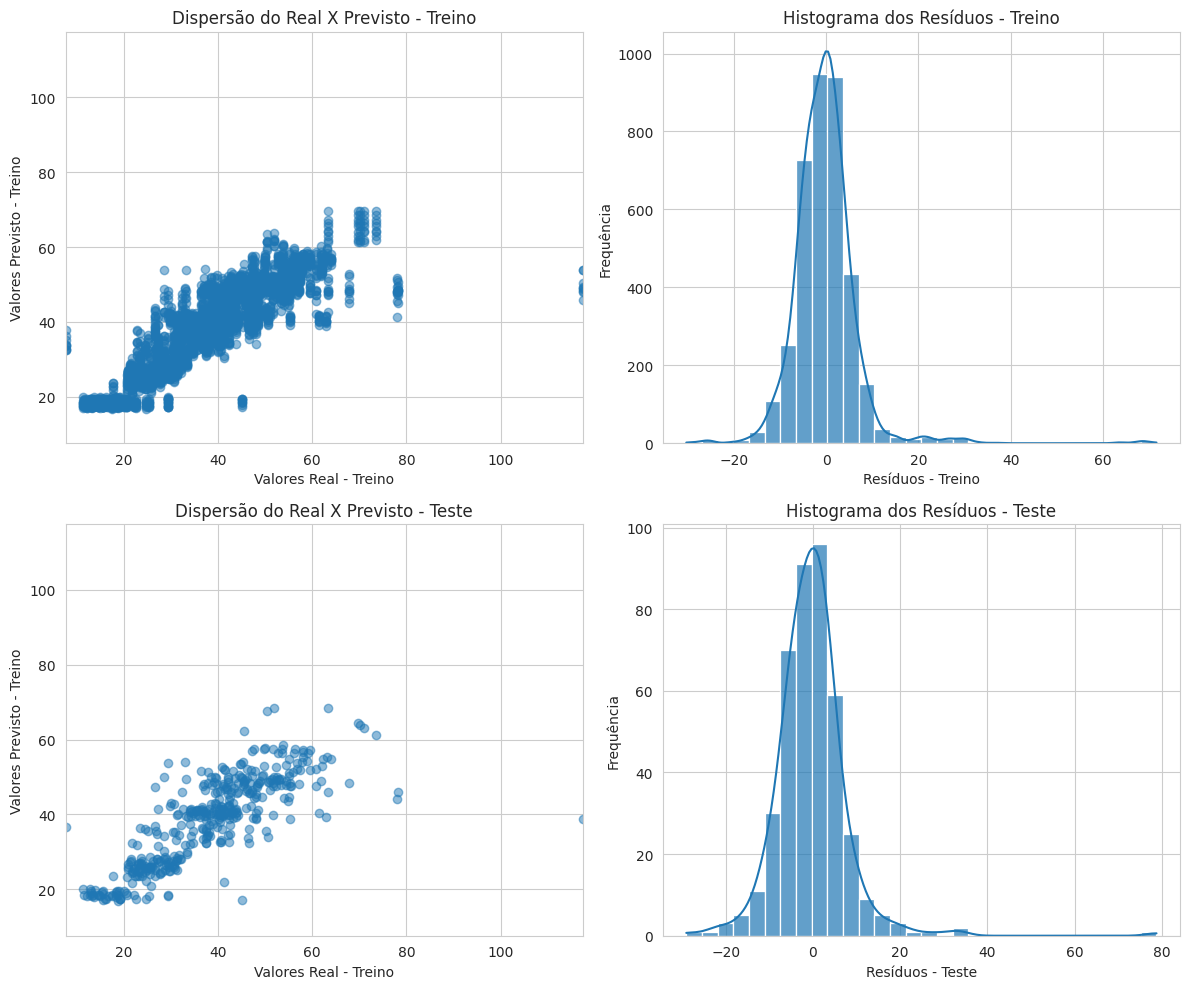

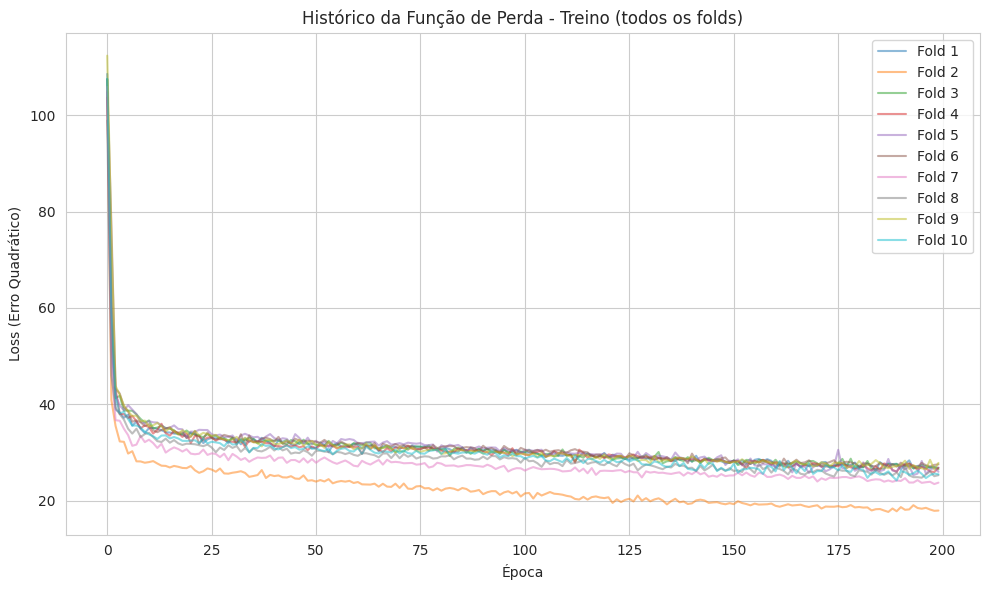

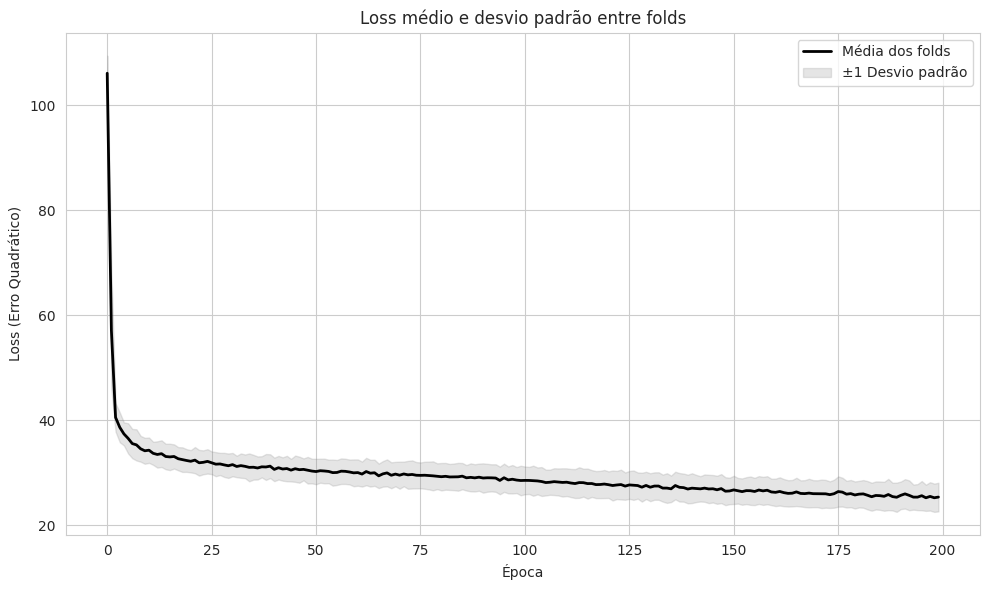

In [8]:

# best_cfg = grid_search(X, y, k_fold,
#                        hidden_units, activations,
#                        epochs_list, learning_rates)

# 2) Treino final com CV para coletar tudo
ls   = best_cfg['layer_sizes']
act  = best_cfg['activation']
ep   = best_cfg['epochs']
# ep = 300
lr   = best_cfg['lr']

all_train_losses = []
y_tr_all, y_trp_all = [], []
y_te_all, y_tep_all   = [], []
cor_tr, cor_te = [], []

eqms, reqms, r2s, h20, h10 = [], [], [], [], []


for train_idx, test_idx in k_fold:
    y_scaler = StandardScaler()

    # 2) Treino e teste
    X_tr, X_te = X[train_idx], X[test_idx]
    y_tr, y_te = y[train_idx].reshape(-1,1), y[test_idx].reshape(-1,1)

    # Normaliza y (fit no treino, transform no teste)
    #
    # y_tr = y_scaler.fit_transform(y_tr)
    # y_te = y_scaler.transform(y_te)

    scaler = QuantileTransformer(n_quantiles=min(X_tr.shape[0],1000), output_distribution='uniform')
    X_tr_n = scaler.fit_transform(X_tr)
    X_te_n = scaler.transform(X_te)

    W, loss_hist = reg_mlp.train_mlp_regression(
        X_tr_n, y_tr, layer_sizes=ls,
        epochs=ep, eta_i=lr, eta_f=lr,
        hidden_activation=act, output_activation='linear',
        verbose=False
    )
    all_train_losses.append(loss_hist)

    y_trp = reg_mlp.predict_mlp_regression(X_tr_n, W, act, 'linear').reshape(-1,1)
    y_tep = reg_mlp.predict_mlp_regression(X_te_n, W, act, 'linear').reshape(-1,1)


    eqm, reqm, r2, hit_20, hit_10, _ = aux.calcular_metricas(y_te, y_tep, aux)
    eqms.append(eqm)
    reqms.append(reqm)
    r2s.append(r2)
    h20.append(hit_20)
    h10.append(hit_10)

    cor_tr.append(np.corrcoef(y_tr.flatten(), y_trp.flatten())[0,1])
    cor_te.append(np.corrcoef(y_te.flatten(), y_tep.flatten())[0,1])

    y_tr_all .extend(y_tr.flatten())
    y_trp_all.extend(y_trp.flatten())
    y_te_all .extend(y_te.flatten())
    y_tep_all.extend(y_tep.flatten())

# 3) Métricas finais
# eqms, reqms, r2s, h20, h10, _ = aux.calcular_metricas(
#     np.array(y_te_all), np.array(y_tep_all), aux)
aux.imprimir_metricas(eqms, reqms, r2s, h20, h10)
aux.imprimir_correlacoes(cor_tr, cor_te, r2s)
aux.analisar_residuos(
    np.array(y_tr_all), np.array(y_trp_all),
    np.array(y_te_all), np.array(y_tep_all),
    aux, titulo="MLP Final"
)

# 4) Plots de loss
aux.plot_folds_loss(all_train_losses)
